# Prediction over the whole state of karnataka

# Importing of libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optim
import numpy as np
from IPython.display import Markdown as md

# Reading the data file 

In [8]:
data = pd.read_csv('covid_data.csv')

# A view into the data available

In [9]:
data.head()

,Patient_Number,Date_Announced,Origin_type,Location,Age,Sex,Status
0,1,09-Mar-20,T,Bengaluru(U),40,M,Clinically recovered
1,2,10-Mar-20,T2P,Bengaluru(U),40,F,Clinically recovered
2,3,10-Mar-20,T2P,Bengaluru(U),17,F,Clinically recovered
3,4,11-Mar-20,T,Bengaluru(U),44,M,Clinically recovered
4,5,12-Mar-20,T,Bengaluru(U),30,M,Clinically recovered


# Data Preparation for the analysis

In [10]:
data['datetime'] = pd.to_datetime(data['Date_Announced'])
data_date=data
data_date.index=data_date['datetime']
data_date = data_date.drop(['datetime'], axis=1)
data_count = data_date.groupby('datetime').count()
data_count = data_count.drop(['Date_Announced','Origin_type','Location','Age','Sex','Status'], axis=1)
data_percentage_change = data_count
data_count = data_count.cumsum()
data_count=data_count.asfreq('D')
data_count['Time Step'] = np.arange(1,len(data_count)+1)
data_count['Patient_Number'].fillna(method='ffill', inplace=True)

# A view in the prepared data

In [32]:
data_count = data_count[['Time Step', 'Patient_Number']]
data_count

,Time Step,Patient_Number
datetime,,
2020-03-09,1,1.0
2020-03-10,2,3.0
2020-03-11,3,4.0
2020-03-12,4,5.0
2020-03-13,5,6.0
2020-03-14,6,6.0
2020-03-15,7,7.0
2020-03-16,8,8.0
2020-03-17,9,11.0


# Visual Representation of the Cummalative patients

In [31]:
plt.plot(data_count['Time Step'],data_count['Patient_Number'])
plt.xlabel('Time Step(Day)')
plt.ylabel('Number of patients')
plt.legend()

# Visual Representation of the trend

In [35]:
trend_percentage=pd.DataFrame(data_count.sort_values(by='datetime', ascending=False))
trend_percentage=trend_percentage.pct_change()
trend_percentage=(trend_percentage*-100)
trend_percentage=trend_percentage.sort_values(by='datetime')
plt.plot(data_count['Time Step'][1:],trend_percentage['Patient_Number'][1:])
plt.xlabel('Time Step(Day)')
plt.ylabel('Percentage of change in number of patients compared to previous day')
# plt.legend()

Text(0, 0.5, 'Percentage of change in number of patients compared to previous day')

# Forcasting of COVID


# Method : Logistic Growth
## Why Logistic Growth?
The reason to use Logistic Growth for modeling the Coronavirus outbreak is that epidemiologists have studied those types of outbreaks and it is well known that the first period of an epidemic follows Exponential Growth and that the total period can be modeled with a Logistic Growth
# Fitting a logistic growth curve to the cummulative data

In [14]:
def logistic(t, a, b, c):
    return c/(1 + a * np.exp(-b*t))
p0 = np.random.exponential(size=3)
bounds = (0,[100000.,1000.,1000000000.])
x = np.array(data_count['Time Step'])
y = np.array(data_count['Patient_Number'])
(a,b,c),cov = optim.curve_fit(logistic,  x, y, bounds=bounds, p0=p0 ,maxfev=1000000)
a,b,c

(99.01554544699455, 0.18508907347678072, 241.1689711971638)

In [16]:
def logistic_1(t):
    return c/(1 + a * np.exp(-b*t))

# Visual representation of the fixed curve onto the data

In [49]:
plt.scatter(x,y)
plt.plot(x,logistic_1(x))
plt.xlabel('Time Step(Day)')
plt.ylabel('Number of patients')
plt.legend(['Data'],['Fixed Growth Curve'])

# Mean Square error of the fixed plot

In [18]:
summation = 0
for i in range(0,len(x)-1):
    difference = y[i] - logistic_1(x[i])
    squared_difference = difference**2
    summation = summation + squared_difference
MSE = summation/len(x)
MSE

7.101732109483814

# Predicting future cases with the help of the obtained curve

In [19]:
md(""" # Predicting for the next """+str(75-len(data_count))+""" days""")

 # Predicting for the next 43 days

In [20]:
x_forecast = np.arange(1,75)

In [21]:
%matplotlib qt

In [51]:
plt.scatter(x,y)
plt.plot(x_forecast,logistic_1(x_forecast))
plt.xlabel('Number of days starting from 09-Mar-2020')  # Add an x-label to the axes.
plt.ylabel('Number of patients')  # Add a y-label to the axes.
plt.title("Prediction of number COVID cases")  # Add a title to the axes.
plt.legend()

No handles with labels found to put in legend.


# Conclusion

In [52]:
md("""- According to this model, c is """+str(int(np.round(c)))+""", that would mean that the maximum limit for the number of infections of Karanataka would be """+str(int(np.round(c)))+""" (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln("""+str(np.round(a))+""") / """+str((b))+""" = day """+str(np.round(np.log(a)/b))+"""
        - and the number of infections at that moment was y = """+str(np.round(c))+""" / 2 = """+str(np.round(c/2))+"""""")

- According to this model, c is 241, that would mean that the maximum limit for the number of infections of Karanataka would be 241 (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln(99.0) / 0.18508907347678072 = day 25.0
        - and the number of infections at that moment was y = 241.0 / 2 = 121.0

# Number for the next 5 days (Predicted patients numbers are cummulative)

In [54]:
dates = pd.date_range(data_count.index[0], periods=74)
dates = {'Date':dates, 'Day':x_forecast, 'Predicted_Patient_Number':np.round(logistic_1(x_forecast))}
dates=pd.DataFrame(dates)
dates.iloc[len(data_count):len(data_count)+5,:]

,Date,Day,Predicted_Patient_Number
32,2020-04-10,33,198.0
33,2020-04-11,34,204.0
34,2020-04-12,35,209.0
35,2020-04-13,36,214.0
36,2020-04-14,37,218.0


In [55]:
dates

,Date,Day,Predicted_Patient_Number
0,2020-03-09,1,3.0
1,2020-03-10,2,3.0
2,2020-03-11,3,4.0
3,2020-03-12,4,5.0
4,2020-03-13,5,6.0
5,2020-03-14,6,7.0
6,2020-03-15,7,9.0
7,2020-03-16,8,10.0
8,2020-03-17,9,12.0
9,2020-03-18,10,15.0


# Visual Representation of the trend over the predictited data over an ideal lockdown

In [57]:
Predicted_trend_percentage = dates 
Predicted_trend_percentage.index=Predicted_trend_percentage['Date']
Predicted_trend_percentage=Predicted_trend_percentage.drop(['Date'],axis=1)
Predicted_trend_percentage=pd.DataFrame(Predicted_trend_percentage.sort_values(by='Date', ascending=False))
Predicted_trend_percentage=Predicted_trend_percentage.pct_change()
Predicted_trend_percentage=(Predicted_trend_percentage*-100)
Predicted_trend_percentage=Predicted_trend_percentage.sort_values(by='Date')
plt.plot(dates['Day'][1:],Predicted_trend_percentage['Predicted_Patient_Number'][1:])

# ----------------------End of the analysis for state----------------------

# Analysis for the cluster

# Results form the cluster Analysis

1)	**High Active Cases:**
- **Districts:** Bengaluru and Mysore
- **Features:**
        •High Active Cases
        •High Imported and Local cases including returnees from the Jamat Tablighi convention
        •High new cases but low growth rate
        •Mortality Rate is also low

2)	**High Mortality:**
- **Districts:** Bagalkot, Tumkuru and Kalaburgi
- **Features:**
        •Low Active Cases
        •High Mortality Rate
        •Low Local and Imported cases including returnees from the Jamat Tablighi
        •Low new cases but high growth rate
    
    
3)	**Low/Moderate Active Cases**
- **Districts:** Bidar, Dakshina Kannada, Uttara Kannada, Dharwad, Gadag, Belagavi, Chikkaballapur, Kodagu, Udupi, Davangere, Mandya, Ballari and Bengaluru Rural
- **Features:**
        •Low to Moderate Active Cases
        •Low Mortality Rate
        •Low growth Rate and new cases
        •Some returnees from Tablighi convention

In [58]:
pd.unique(data['Location'])

array(['Bengaluru(U)', 'Kalaburagi', 'Kodagu', 'Chikaballapura', 'Mysuru',
       'Dharwad', 'Dakshina Kannada', 'Uttara Kannada', 'Davanagere',
       'Udupi', 'Tumkuru', 'Ballari', 'Bidar', 'Bagalkot', 'Belagavi',
       'Bengaluru Rural', 'Gadag', 'Mandya'], dtype=object)

In [59]:
Districtwise_df = {}
for i in pd.unique(data['Location']):
    Districtwise_df[i] =  data[data['Location'] == i]

# ------------------Cluster:High Active Cases-------------------

# Districts:Bengaluru(U) and Mysuru

In [60]:
High_Active_Cases = [Districtwise_df['Bengaluru(U)'], Districtwise_df['Mysuru']]
High_Active_Cases = pd.concat(High_Active_Cases)
High_Active_Cases['datetime'] = pd.to_datetime(High_Active_Cases['Date_Announced'])
High_Active_Cases_date = High_Active_Cases
High_Active_Cases.index=High_Active_Cases['datetime']
High_Active_Cases = High_Active_Cases.drop(['datetime'], axis=1)
High_Active_Cases = High_Active_Cases.groupby('datetime').count()
High_Active_Cases = High_Active_Cases.drop(['Date_Announced','Origin_type','Location','Age','Sex','Status'], axis=1)
High_Active_Cases = High_Active_Cases.cumsum()
High_Active_Cases = High_Active_Cases.asfreq('D')
High_Active_Cases['Time Step'] = np.arange(1,len(High_Active_Cases)+1)
High_Active_Cases['Patient_Number'].fillna(method='ffill', inplace=True)
High_Active_Cases.head()

,Patient_Number,Time Step
datetime,,
2020-03-09,1.0,1
2020-03-10,3.0,2
2020-03-11,4.0,3
2020-03-12,5.0,4
2020-03-13,5.0,5


# Cummulative patients

In [61]:
plt.plot(High_Active_Cases['Time Step'],High_Active_Cases['Patient_Number'])

# Day wise change in Trend

In [62]:
trend_percentage = pd.DataFrame(High_Active_Cases.sort_values(by='datetime', ascending=False))
trend_percentage = trend_percentage.pct_change()
trend_percentage = (trend_percentage*-100)
trend_percentage = trend_percentage.sort_values(by='datetime')
plt.plot(High_Active_Cases['Time Step'][1:],trend_percentage['Patient_Number'][1:])

In [63]:
High_Active_Cases_x = np.array(High_Active_Cases['Time Step'])
High_Active_Cases_y = np.array(High_Active_Cases['Patient_Number'])
High_Active_Cases_p0 = np.random.exponential(size=3)
High_Active_Cases_bounds = (0,[100000.,1000.,1000000000.])
(High_Active_Cases_a,High_Active_Cases_b,High_Active_Cases_c),High_Active_Cases_cov = optim.curve_fit(logistic,  High_Active_Cases_x, High_Active_Cases_y, bounds=High_Active_Cases_bounds, p0=High_Active_Cases_p0)
High_Active_Cases_a,High_Active_Cases_b,High_Active_Cases_c

(61.09849063056886, 0.17870743987894205, 119.04440052092347)

In [64]:
def logistic_High_Active_Cases(t):
    return High_Active_Cases_c/(1 + High_Active_Cases_a * np.exp((-High_Active_Cases_b*t)))

In [65]:
plt.scatter(High_Active_Cases_x,High_Active_Cases_y)
plt.plot(High_Active_Cases_x,logistic_High_Active_Cases(High_Active_Cases_x))

In [66]:
summation = 0
for i in range(0,len(High_Active_Cases_x)-1):
    difference = High_Active_Cases_y[i] - logistic_High_Active_Cases(High_Active_Cases_x[i])
    squared_difference = difference**2
    summation = summation + squared_difference
MSE = summation/len(High_Active_Cases_x)
MSE

4.063690246772429

In [69]:
plt.scatter(High_Active_Cases_x,High_Active_Cases_y)
plt.plot(x_forecast,logistic_High_Active_Cases(x_forecast))
plt.xlabel('Number of days starting from 09-Mar-2020')  # Add an x-label to the axes.
plt.ylabel('Number of patients')  # Add a y-label to the axes.
plt.title("Prediction of number COVID cases")  # Add a title to the axes.
plt.legend()

No handles with labels found to put in legend.


# Conclusion

In [70]:
md("""- According to this model, c is """+str(int(np.round(High_Active_Cases_c)))+""", that would mean that the maximum limit for the number of infections of Karanataka would be """+str(int(np.round(High_Active_Cases_c)))+""" (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln("""+str(np.round(High_Active_Cases_a))+""") / """+str((High_Active_Cases_b))+""" = day """+str(np.round(np.log(High_Active_Cases_a)/High_Active_Cases_b))+"""
        - and the number of infections at that moment was y = """+str(np.round(High_Active_Cases_c))+""" / 2 = """+str(np.round(High_Active_Cases_c/2))+"""""")

- According to this model, c is 119, that would mean that the maximum limit for the number of infections of Karanataka would be 119 (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln(61.0) / 0.17870743987894205 = day 23.0
        - and the number of infections at that moment was y = 119.0 / 2 = 60.0

In [71]:
High_Active_Cases_dates = pd.date_range(High_Active_Cases.index[0], periods=74)
High_Active_Cases_dates = {'Date':High_Active_Cases_dates, 'Day':x_forecast, 'Predicted_Patient_Number':np.round(logistic_High_Active_Cases(x_forecast))}
High_Active_Cases_dates=pd.DataFrame(High_Active_Cases_dates)
High_Active_Cases_dates.iloc[len(High_Active_Cases):len(High_Active_Cases)+5,:]

,Date,Day,Predicted_Patient_Number
32,2020-04-10,33,102.0
33,2020-04-11,34,104.0
34,2020-04-12,35,107.0
35,2020-04-13,36,108.0
36,2020-04-14,37,110.0


In [74]:
High_Active_Cases_dates

,Date,Day,Predicted_Patient_Number
0,2020-03-09,1,2.0
1,2020-03-10,2,3.0
2,2020-03-11,3,3.0
3,2020-03-12,4,4.0
4,2020-03-13,5,5.0
5,2020-03-14,6,5.0
6,2020-03-15,7,6.0
7,2020-03-16,8,8.0
8,2020-03-17,9,9.0
9,2020-03-18,10,11.0


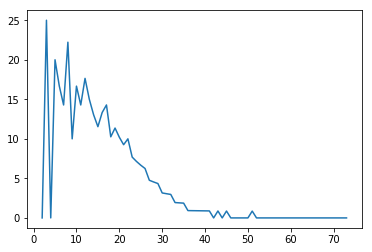

In [574]:
Predicted_trend_percentage = High_Active_Cases_dates 
Predicted_trend_percentage.index=Predicted_trend_percentage['Date']
Predicted_trend_percentage=Predicted_trend_percentage.drop(['Date'],axis=1)
Predicted_trend_percentage=pd.DataFrame(Predicted_trend_percentage.sort_values(by='Date', ascending=False))
Predicted_trend_percentage=Predicted_trend_percentage.pct_change()
Predicted_trend_percentage=(Predicted_trend_percentage*-100)
Predicted_trend_percentage=Predicted_trend_percentage.sort_values(by='Date')
plt.plot(dates['Day'][1:],Predicted_trend_percentage['Predicted_Patient_Number'][1:])

# ------------------End of High Active Cases Cluster-------------------

# ------------------Hotspots of Karnataka-------------------

# Based on Exploratory and cluster analysis, the hotspots can be identified as
    1)	Bengaluru
    2)	Mysuru
    3)	Bagalkot
    4)	Kalaburgi
    5)	Belagavi
    6)	Dakshina Kannada

# A view in the prepared data

In [603]:
High_Mortality = [Districtwise_df['Bengaluru(U)'], Districtwise_df['Mysuru'],Districtwise_df['Bagalkot'],Districtwise_df['Kalaburagi'],Districtwise_df['Belagavi'],Districtwise_df['Dakshina Kannada']]
High_Mortality = pd.concat(High_Mortality)
High_Mortality['datetime'] = pd.to_datetime(High_Mortality['Date_Announced'])
High_Mortality_date = High_Mortality
High_Mortality.index=High_Mortality['datetime']
High_Mortality = High_Mortality.drop(['datetime'], axis=1)
High_Mortality = High_Mortality.groupby('datetime').count()
High_Mortality = High_Mortality.drop(['Date_Announced','Origin_type','Location','Age','Sex','Status'], axis=1)
High_Mortality = High_Mortality.cumsum()
High_Mortality = High_Mortality.asfreq('D')
High_Mortality['Time Step'] = np.arange(1,len(High_Mortality)+1)
High_Mortality['Patient_Number'].fillna(method='ffill', inplace=True)
High_Mortality.head()

,Patient_Number,Time Step
datetime,,
2020-03-09,1.0,1
2020-03-10,3.0,2
2020-03-11,4.0,3
2020-03-12,5.0,4
2020-03-13,6.0,5


# Cummulative patients

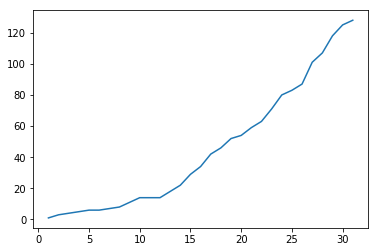

In [592]:
plt.plot(High_Mortality['Time Step'],High_Mortality['Patient_Number'])

# Day wise change in Trend

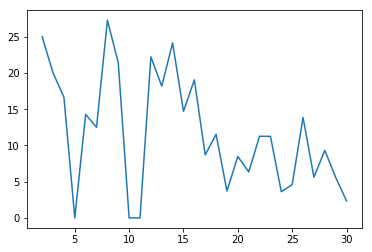

In [593]:
trend_percentage = pd.DataFrame(High_Mortality.sort_values(by='datetime', ascending=False))
trend_percentage = trend_percentage.pct_change()
trend_percentage = (trend_percentage*-100)
trend_percentage = trend_percentage.sort_values(by='datetime')
plt.plot(High_Mortality['Time Step'][1:],trend_percentage['Patient_Number'][1:])

In [594]:
High_Mortality_x = np.array(High_Mortality['Time Step'])
High_Mortality_y = np.array(High_Mortality['Patient_Number'])
High_Mortality_p0 = np.random.exponential(size=3)
High_Mortality_bounds = (0,[100000.,3.,1000000000.])
(High_Mortality_a,High_Mortality_b,High_Mortality_c),High_Mortality_cov = optim.curve_fit(logistic,  High_Mortality_x, High_Mortality_y, bounds=High_Mortality_bounds, p0=High_Mortality_p0)
High_Mortality_a,High_Mortality_b,High_Mortality_c

(62.0895961052034, 0.16126692766727957, 181.79020315627176)

In [595]:
def logistic_High_Mortality(t):
    return High_Mortality_c/(1 + High_Mortality_a * np.exp((-High_Mortality_b*t)))

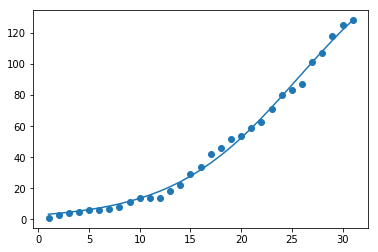

In [596]:
plt.scatter(High_Mortality_x,High_Mortality_y)
plt.plot(High_Mortality_x,logistic_High_Mortality(High_Mortality_x))

In [597]:
summation = 0
for i in range(0,len(High_Mortality_x)-1):
    difference = High_Mortality_y[i] - logistic_High_Mortality(High_Mortality_x[i])
    squared_difference = difference**2
    summation = summation + squared_difference
MSE = summation/len(High_Mortality_x)
MSE

7.389897113864219

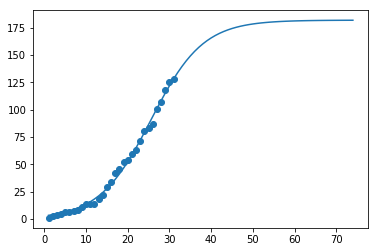

In [598]:
plt.scatter(High_Mortality_x,High_Mortality_y)
plt.plot(x_forecast,logistic_High_Mortality(x_forecast))

In [599]:
md("""- According to this model, c is """+str(int(np.round(High_Mortality_c)))+""", that would mean that the maximum limit for the number of infections would be """+str(int(np.round(High_Mortality_c)))+""" (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln("""+str(np.round(High_Mortality_a))+""") / """+str((High_Mortality_b))+""" = day """+str(np.round(np.log(High_Mortality_a)/High_Mortality_b))+"""
        - and the number of infections at that moment was y = """+str(np.round(High_Mortality_c))+""" / 2 = """+str(np.round(High_Mortality_c/2))+"""""")


- According to this model, c is 182, that would mean that the maximum limit for the number of infections would be 182 (Ideal case of perfect lockdown).
- when the maximum growth rate occurred according to this model:
        - the moment in time was: t = ln(a) / b = ln(62.0) / 0.16126692766727957 = day 26.0
        - and the number of infections at that moment was y = 182.0 / 2 = 91.0

In [600]:
High_Mortality_dates = pd.date_range(High_Mortality.index[0], periods=74)
High_Mortality_dates = {'Date':High_Mortality_dates, 'Day':x_forecast, 'Predicted_Patient_Number':np.round(logistic_High_Mortality(x_forecast))}
High_Mortality_dates=pd.DataFrame(High_Mortality_dates)
High_Mortality_dates.iloc[len(High_Mortality):len(High_Mortality)+5,:]

,Date,Day,Predicted_Patient_Number
31,2020-04-09,32,134.0
32,2020-04-10,33,139.0
33,2020-04-11,34,144.0
34,2020-04-12,35,149.0
35,2020-04-13,36,153.0


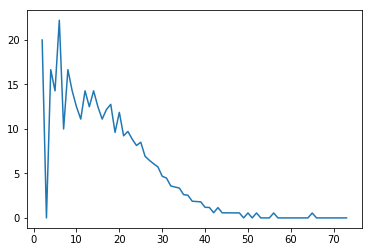

In [601]:
Predicted_trend_percentage = High_Mortality_dates 
Predicted_trend_percentage.index=Predicted_trend_percentage['Date']
Predicted_trend_percentage=Predicted_trend_percentage.drop(['Date'],axis=1)
Predicted_trend_percentage=pd.DataFrame(Predicted_trend_percentage.sort_values(by='Date', ascending=False))
Predicted_trend_percentage=Predicted_trend_percentage.pct_change()
Predicted_trend_percentage=(Predicted_trend_percentage*-100)
Predicted_trend_percentage=Predicted_trend_percentage.sort_values(by='Date')
plt.plot(dates['Day'][1:],Predicted_trend_percentage['Predicted_Patient_Number'][1:])

# Impression on the population

In [605]:
Population_data = pd.read_excel('Population_district_wise.xlsx')

In [607]:
Population_data.dropna()

,District Code,State/District,Population 2011,Unnamed: 3,Unnamed: 4,Percentage decadal growth rate of population,Unnamed: 6,Sex ratio (females per 1000 males),Unnamed: 8,Population density,Unnamed: 10
2,-,KARNATAKA,61095297,30966657,30128640,17.51,15.67,965.0,968.0,276,319.0
3,1,BELGAUM,4779661,2423063,2356598,17.61,13.38,960.0,969.0,314,356.0
4,2,BAGALKOT,1889752,950111,939641,18.82,14.46,980.0,984.0,251,288.0
5,3,BIJAPUR,2177331,1111022,1066309,17.51,20.38,950.0,954.0,172,207.0
6,4,BIDAR,1703300,870665,832635,19.63,13.16,949.0,952.0,276,312.0
7,5,RAICHUR,1928812,964511,964301,23.52,15.27,983.0,992.0,198,228.0
8,6,KOPPAL,1389920,699926,689994,24.84,16.32,983.0,983.0,215,250.0
9,7,GADAG,1064570,537147,527423,13.13,9.61,969.0,978.0,209,229.0
10,8,DHARWAD,1847023,937206,909817,16.68,15.13,949.0,967.0,377,434.0
11,9,UTTARA KANNADA,1437169,726256,710913,10.93,6.15,971.0,975.0,132,140.0


In [ ]:
Logistic Growth for modeling the Coronavirus outbreak is that epidemiologists have studied those 
types of outbreaks and it is well known that the first period of an epidemic follows Exponential Growth and that the total 
period can be modeled with a Logistic Growth